In [1]:
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

python_root = '../'
sys.path.insert(0, python_root)

from model.datagenerator import ImageDataGenerator

%matplotlib inline

# Restore model

In [2]:
sess = tf.InteractiveSession()
saver = tf.train.import_meta_graph('../logs/tmp/triplet_loss_batch_all_ckpt/bgr-d_model_epoch30.ckpt.meta')
saver.restore(sess, '../logs/tmp/triplet_loss_batch_all_ckpt/bgr-d_model_epoch30.ckpt')

INFO:tensorflow:Restoring parameters from ../logs/tmp/triplet_loss_batch_all_ckpt/bgr-d_model_epoch30.ckpt


# Visualizae the graph
From http://nbviewer.jupyter.org/github/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb

In [3]:
from __future__ import print_function
import os
from io import BytesIO
import numpy as np
from functools import partial
import PIL.Image
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = tf.compat.as_bytes("<stripped %d bytes>"%size)
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [4]:
graph = tf.get_default_graph()
show_graph(graph)

# Visualize kernels

In [5]:
conv1_kernels = sess.run('conv1/weights:0')
conv1_kernels_rgb = conv1_kernels[:,:,:3,:]
conv1_kernels_depth = conv1_kernels[:,:,-1,:]

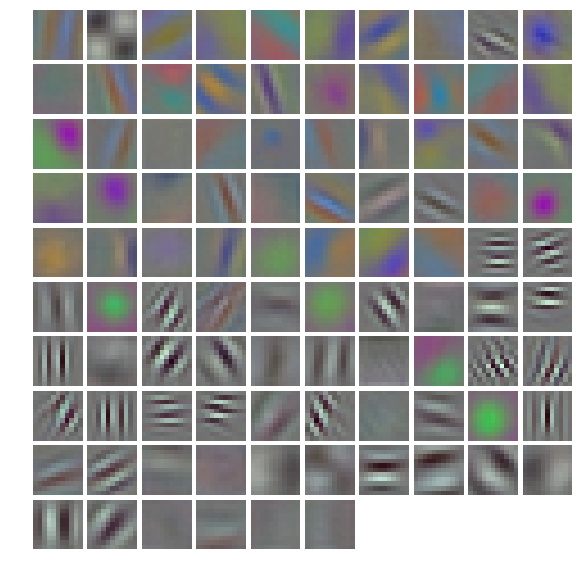

In [6]:
from tools.visualization import vis_square
plt.rcParams['figure.figsize'] = (10, 10) 

vis_square(conv1_kernels_rgb.transpose(3,0,1,2))

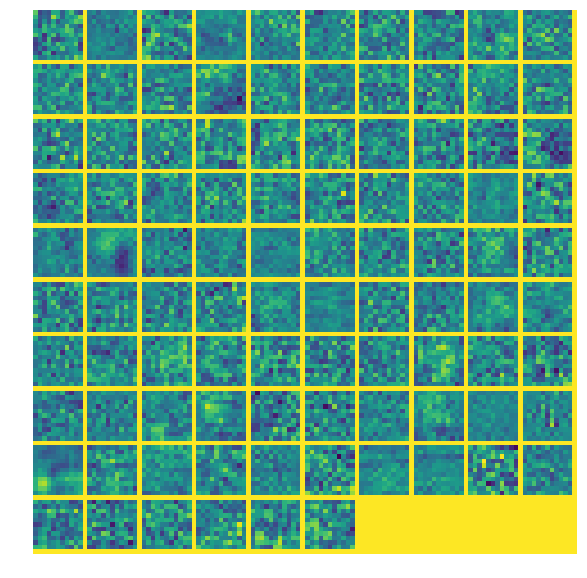

In [7]:
vis_square(conv1_kernels_depth.transpose(2,0,1))

# Embeddings learned for test set

In [8]:
# According to ../split_dataset_with_labels_world.py
test = []
traj = 1
frames_total = 300
for frame_id in range(frames_total):
    if frame_id % 5 == 3:
        test.append(frame_id)
        continue

In [9]:
test_file = '../test.txt'
test_set_size = 0
with open(test_file) as f:
    for i, l in enumerate(f):
        pass
    test_set_size = i + 1 
    
print("Test set has {} lines ".format(test_set_size))

Test set has 4393 lines 


In [10]:
train_set_mean = np.array([22.4536157, 20.11461999, 5.61416132, 605.87199598])
test_generator = ImageDataGenerator(test_file, image_type='bgr-d', 
                                    mean=train_set_mean)

In [11]:
x = graph.get_tensor_by_name('Placeholder:0')  # input images
labels = graph.get_tensor_by_name('Placeholder_1:0')  # labels of input images
keep_prob = graph.get_tensor_by_name('Placeholder_2:0')  # dropout probability 
embeddings = graph.get_tensor_by_name('l2_normalize:0')

In [12]:
%%time
batch_size = int(x.shape[0])
test_embeddings_all = np.empty((0, int(embeddings.shape[1])), dtype=np.float32)
test_generator.reset_pointer()

for i in range(test_set_size / batch_size):
    batch_x, batch_labels = test_generator.next_batch(batch_size)
    output = sess.run(embeddings, feed_dict={x: batch_x,
                                                 labels: batch_labels,
                                                 keep_prob: 1.})
    test_embeddings_all = np.vstack([test_embeddings_all, output])
    # Display every 5 steps
    if i % 5 == 0:
        print("Embeddings got for {} lines ".format(test_embeddings_all.shape[0]))
            
lines_totoal = test_embeddings_all.shape[0]
print("Embeddings got for {} lines ".format(lines_totoal))

Embeddings got for 128 lines 
Embeddings got for 768 lines 
Embeddings got for 1408 lines 
Embeddings got for 2048 lines 
Embeddings got for 2688 lines 
Embeddings got for 3328 lines 
Embeddings got for 3968 lines 
Embeddings got for 4352 lines 
CPU times: user 7min 31s, sys: 37.2 s, total: 8min 8s
Wall time: 1min 32s


# K-means clustering with obtained embeddings

In [13]:
from sklearn.cluster import KMeans

lines_features = test_embeddings_all

n_clusters = 12
kmeans = KMeans(n_clusters, init='k-means++').fit(lines_features)
cluster_labels = kmeans.labels_
count = cluster_labels.shape[0]

In [14]:
from tools.visualization import get_lines_world_coordinates_with_instances

data_lines_world = get_lines_world_coordinates_with_instances(trajectory=traj, frames=test)
data_lines_world = data_lines_world[:count]
instance_labels = data_lines_world[:, -1]

Total number of lines: 4393
Number of unique instance labels for lines: 52


In [15]:
from tools.visualization import pcl_lines_for_plot

pcl_lines_open3d = pcl_lines_for_plot(data_lines_world, lines_color=cluster_labels)

In [16]:
import open3d

open3d.draw_geometries(pcl_lines_open3d[:])

# See embeddings in the feature space, colored with instance label

In [17]:
from tensorflow.contrib.tensorboard.plugins import projector

LOG_DIR = os.path.abspath('../logs/tmp/embedding_logs')
# Create parent path if it doesn't exist
if not os.path.isdir(LOG_DIR): os.makedirs(LOG_DIR)
    
metadata = os.path.join(LOG_DIR, 'embedding_metadata.tsv')

test_embeddings = tf.Variable(test_embeddings_all, name='test_embeddings')

with open(metadata, 'w') as metadata_file:
    for label in instance_labels:
        metadata_file.write('%d\n' % label)
        
with tf.Session() as sess:
    saver = tf.train.Saver([test_embeddings])

    sess.run(test_embeddings.initializer)
    saver.save(sess, os.path.join(LOG_DIR, 'test_embeddings.ckpt'))

    config = projector.ProjectorConfig()
    # One can add multiple embeddings.
    embedding = config.embeddings.add()
    embedding.tensor_name = test_embeddings.name
    # Link this tensor to its metadata file (e.g. labels).
    embedding.metadata_path = metadata
    # Saves a config file that TensorBoard will read during startup.
    projector.visualize_embeddings(tf.summary.FileWriter(LOG_DIR), config)

In [18]:
!tensorboard --logdir ../logs/tmp/embedding_logs --port=6007

TensorBoard 1.9.0 at http://chengkun-asl:6007 (Press CTRL+C to quit)
^C
